In [1]:
# !pip install torch torchvision transformers datasets

In [2]:
import torch
import torch.nn.functional as F
from configuration import config
from torchvision import transforms
from datasets import load_dataset
from model import model
from PIL import Image
from diffusers import DDPMScheduler
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path
from accelerate import notebook_launcher
import os

c:\Users\User\.conda\envs\coding\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = load_dataset("nielsr/CelebA-faces", split="train").select(range(21000))

In [4]:
ds

Dataset({
    features: ['image'],
    num_rows: 21000
})

C:\Users\User\AppData\Local\Temp\ipykernel_16168\3785189040.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


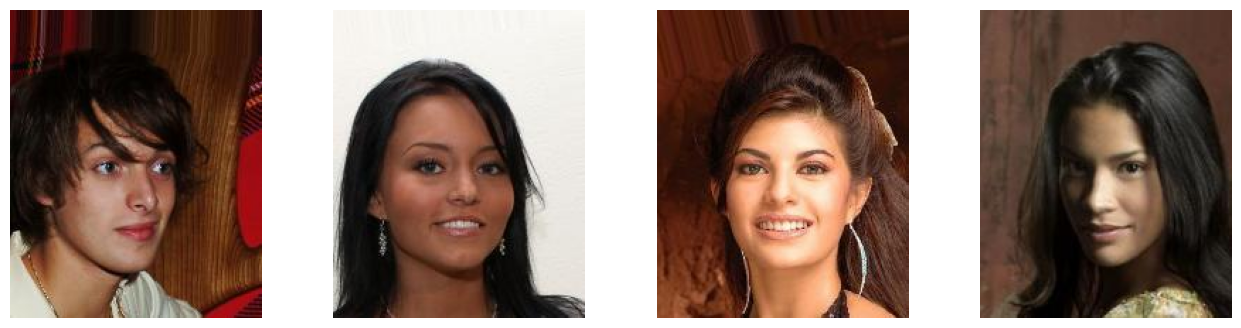

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(ds[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [6]:
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)), # обрезаем изображение
        transforms.RandomHorizontalFlip(), # случайный поворот
        transforms.ToTensor(), # конвертим в тензор
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [7]:
def transform(examples): # функция для предобработки изображения перед пропуском через модель
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    # выше мы для всех изображений применяем конвертацию в RGB, а затем обрабатываем созданной раннее функцией
    return {"images" : images}

In [8]:
ds.set_transform(transform) # задаем эту функцию для датасета

In [9]:
train_dataloader = torch.utils.data.DataLoader(ds, batch_size=config.train_batch_size, shuffle=True)

In [10]:
sample_image = ds[0]["images"].unsqueeze(0)
print("Форма входных данных:", sample_image.shape)

Форма входных данных: torch.Size([1, 3, 64, 64])


In [11]:
print("Форма выходных данных:", model(sample_image, timestep=0).sample.shape)

Форма выходных данных: torch.Size([1, 3, 64, 64])


In [12]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

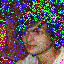

In [13]:
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1) * 127.5).type(torch.uint8).numpy()[0])
# здесь мы совершили некоторые преобразования, из нормализованного изображения сделали обычное, ..
# .. привели в тип данных unsigned int который как раз подходит своим диапазоном значений под изображения ..
# .. и преобразовали в массив numpy для корректного отображения инструментом Image библиотеки PIL

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate) # оптимизатор
lr_scheduler = get_cosine_schedule_with_warmup( # создадим scheduler
    optimizer=optimizer, # указали оптимизатор
    num_warmup_steps=config.lr_warmup_steps, 
    num_training_steps=(len(train_dataloader) * config.num_epochs), # количество шагов обучения
)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
device

device(type='cuda')

In [17]:
def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device=device).manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=4, cols=4)

    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [18]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )

    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64,
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)


In [19]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

In [20]:
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


c:\Users\User\.conda\envs\coding\Lib\site-packages\accelerate\accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Epoch 0:   0%|          | 0/329 [00:00<?, ?it/s]c:\Users\User\.conda\envs\coding\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\MHA.cpp:676.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 0: 100%|██████████| 329/329 [02:29<00:00,  1.19it/s, loss=0.0641, lr=6.58e-5, step=328]

[2024-12-21 20:22:15,213] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.


c:\Users\User\.conda\envs\coding\Lib\site-packages\deepspeed\runtime\zero\linear.py:47: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @autocast_custom_fwd
c:\Users\User\.conda\envs\coding\Lib\site-packages\deepspeed\runtime\zero\linear.py:66: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @autocast_custom_bwd
W1221 20:22:16.001000 16168 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
Epoch 52:   5%|▍         | 16/329 [00:06<02:19,  2.25it/s, loss=0.0232, lr=4.79e-5, step=17123]

KeyboardInterrupt: 